### **GPU 설정**

In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2'

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

- OOM 문제 때문에 메모리 얼마나 쌓이는지 보려고 set_memory_growth를 했습니다.

### **csv 확인하기**

In [3]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,ID,label
0,0,5
1,1,0
2,2,4
3,3,1
4,4,9


In [4]:
import pandas as pd

sub_df = pd.read_csv("sample_submission.csv")
sub_df.head()

,ID,label
0,50000,-1
1,50001,-1
2,50002,-1
3,50003,-1
4,50004,-1


### **데이터 확인하기**

In [1]:
import h5py
import numpy as np
from tqdm import tqdm

train_all = h5py.File("train.h5", 'r')
test_all = h5py.File("test.h5", 'r')

##### **정사영**

In [3]:
def dots_to_img24(dots, img_size=46):
    imgs = []
    shadow_xyz = dots[:, [[0,1], [0,2], [1,2]]]
    shadow_xyz = np.transpose(shadow_xyz, (1, 0, 2)) # (3, n, 2)
    shadow_xyz = (shadow_xyz+0.75)/1.5
    shadow_xyz = np.round(shadow_xyz*img_size)
    shadow_xyz = np.clip(shadow_xyz, 0, img_size-1).astype(np.int32)
    for shadow in shadow_xyz:
        board = np.zeros((img_size, img_size), dtype=np.float32)
        board[shadow[:,0], shadow[:,1]] = 1.
        board_flip = board[:,::-1]
        for i in range(4):
            imgs.append(np.rot90(board, k=i))
            imgs.append(np.rot90(board_flip, k=i))
    return imgs

def img24_to_grid_img(img24, img_size=46):
    board = np.zeros((img_size*5+16, img_size*5+16), dtype=np.float32)
    for i, img in enumerate(img24):
        cur_x = (i%5)*(img_size+4)
        cur_y = (i//5)*(img_size+4)
        board[cur_y:cur_y+img_size, cur_x:cur_x+img_size] = img
        
    board = np.pad(board, ((5,5),(5,5)), 'constant', constant_values=0)
    return board

- test 숫자데이터가 회전되어 있기 때문에 6방향에서 바라볼 필요가 있다고 생각했습니다.
- 6방향에서 90도씩 4번 회전하여 24개의 이미지가 나왔습니다.
- 모델끝단에 GlobalAvgPool을 하기 때문에 위치적특성은 사라진다 생각하여 한이미지에 24개 이미지를 넣었습니다.

(256, 256)


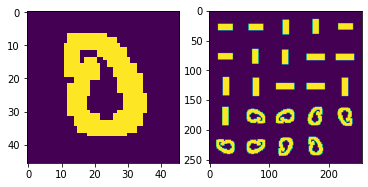

In [4]:
import matplotlib.pyplot as plt

dots = np.array(train_all[str(234)])
img24 = dots_to_img24(dots)
grid_img = img24_to_grid_img(img24)

print(grid_img.shape)
plt.subplot(121)
plt.imshow(img24[23])
plt.subplot(122)
plt.imshow(grid_img)

##### **Data Augmentation**

- testset이 회전되어있으니 trainset도 회전을 주어야 한다고 생각했습니다.

- 아래 공식을 사용했습니다.

![image](https://user-images.githubusercontent.com/48349693/191392909-fd233655-e25f-45eb-86d6-e6049d128c2c.png)

In [8]:
import numpy as np

def rotate(a, b, c, dots):
    mx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
    my = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
    mz = np.array([[np.cos(c), -np.sin(c), 0], [np.sin(c), np.cos(c), 0], [0, 0, 1]])
    m = np.dot(np.dot(mx,my),mz)
    dots = np.dot(dots, m.T)
    return dots

- Rxyz = Rx X Ry X Rz = (3,3) X (3,3) X (3,3) = (3,3)
- dots = (n,3)
- rotated_dots = (Rxyz X dots.T).T = ((3,3) X (3,n)).T = (n,3) X (3,3).T = dots X Rxyz.T

(256, 256)


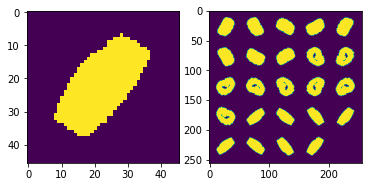

In [7]:
import matplotlib.pyplot as plt

dots = np.array(train_all[str(234)])
dots = rotate(np.pi/3,np.pi/3,np.pi/3, dots)
img24 = dots_to_img24(dots)
grid_img = img24_to_grid_img(img24)

print(grid_img.shape)
plt.subplot(121)
plt.imshow(img24[23])
plt.subplot(122)
plt.imshow(grid_img)

- 회전된 3D데이터를 전처리해서 한 번 출력해보았습니다.

### **Layer 정의**

In [11]:
class CosSimLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes, regularizer=None, name='CosSimLayer', **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.regularizer = regularizer

    def get_config(self):
        config = super().get_config()
        config.update({"n_classes":self.n_classes, "regularizer":self.regularizer})
        return config
    
    def build(self, embedding_shape):
        self._w = self.add_weight(shape=(embedding_shape[-1], self.n_classes),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  regularizer=self.regularizer,
                                  name='cosine_weights')

    def call(self, embedding, training=None):
        # Normalize features and weights and compute dot product
        x = tf.nn.l2_normalize(embedding, axis=1, name='normalize_prelogits') # (batch, 4096)
        w = tf.nn.l2_normalize(self._w, axis=0, name='normalize_weights') # (4096, 10)
        cosine_sim = tf.matmul(x, w, name='cosine_similarity') # (batch, 10)
        return cosine_sim

- 이전 레이어의 output과 weight와의 코사인유사도를 output으로 주는 레이어입니다.
- 내적 공식 : |A||B|cosΘ = A·B = a1b1 + a2b2 + ...
- cosΘ 만을 구하기 위해 각 |A|,|B|는 1이어야 하므로 l2_normalize하면 됩니다.
- 사실 레이어의 forward연산과 비슷한데 l2_normalize한것과 bias가 없는것 뿐입니다.

In [12]:
class SoftmaxHead(tf.keras.layers.Layer):
    def __init__(self, scale=30, name="SoftmaxHead", **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = scale
        self.layer = tf.keras.layers.Activation("softmax")
    
    def call(self, logit):
        return self.layer(logit * self.scale)

- 코사인유사도값에 scale을 준 softmax layer입니다.
- 여기서 scale만 더 낮추면 Calibration 효과가 생깁니다. (실제 확률?)
- 참고 : [Calibration](https://3months.tistory.com/490)

### **Loss 정의**

In [10]:
class CurricularFaceLoss(tf.keras.losses.Loss):
    def __init__(self, scale=30, margin=0.5, alpha=0.99, name="CurricularFaceLoss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = scale
        self.margin = margin
        self.alpha = alpha
        self.t_value = tf.Variable(0., name='t-value')
        self.eps = 1e-7
        self.training = True
    
    def positive_forward(self, y_logit):
        cosine_sim = y_logit 
        theta_margin = tf.math.acos(cosine_sim) + self.margin
        y_logit_pos = tf.math.cos(theta_margin)
        return y_logit_pos
    
    def negative_forward(self, y_logit_pos_masked, y_logit):
        hard_sample_mask = y_logit_pos_masked < y_logit # (N, n_classes)
        y_logit_neg = tf.where(hard_sample_mask, tf.square(y_logit)+self.t_value*y_logit, y_logit)
        return y_logit_neg
    
    def forward(self, y_true, y_logit):
        y_logit = tf.clip_by_value(y_logit, -1.0+self.eps, 1.0-self.eps)
        # y_true*y_logit 로 서로 곱하면서 결국 y_true가 1인 위치의 값만 남고 나머지는 전부 0
        y_logit_masked = tf.expand_dims(tf.reduce_sum(y_true*y_logit, axis=1), axis=1) # (N, 1)
        y_logit_pos_masked = self.positive_forward(y_logit_masked) # (N, 1)
        y_logit_neg = self.negative_forward(y_logit_pos_masked, y_logit) # (N, n_classes)
        # update t
        if self.training:
            r = tf.reduce_mean(y_logit_pos_masked)
            self.t_value.assign(self.alpha*r + (1-self.alpha)*self.t_value)
        
        y_true = tf.cast(y_true, dtype=tf.bool)
        return tf.where(y_true, y_logit_pos_masked, y_logit_neg)
    
    def call(self, y_true, y_logit): # shape(N, n_classes)
        y_logit_fixed = self.forward(y_true, y_logit)
        loss = tf.nn.softmax_cross_entropy_with_logits(y_true, y_logit_fixed*self.scale)
        loss = tf.reduce_mean(loss)
        return loss

- y_logit은 모델의 output이며 즉, 코사인유사도입니다. (값 범위 -1 ~ 1)
- y_logit의 positive란 y_true의 1값이 위치하는 자리의 y_logit을 의미합니다.
- y_logit의 positive에 margin을 준 형태는 ArcFace
- 추가로 negative의 hard sample에 대해서도 처리를 한 형태를 CurricularFace입니다.
- y_logit의 positive는 값을 줄이고 negative는 값을 늘려 최종적으로 loss값이 팽창합니다.
- t값은 positive값이 클수록 점차 커지며 hard sample에 대한 가중값도 커집니다.

- 참고 : [CurricularFace](https://emkademy.medium.com/angular-margin-losses-for-representative-embeddings-training-arcface-2018-vs-mv-arc-softmax-96b54bcd030b)

### Metric 정의

In [19]:
class CosSimAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="CosSimAccuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.softmax = SoftmaxHead()
        self.accuracy_metric = tf.keras.metrics.Accuracy()
        
    def update_state(self, y_true, y_logit, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(self.softmax(y_logit), axis=1)
        self.accuracy_metric.update_state(y_true, y_pred)
        
    def result(self):
        return self.accuracy_metric.result()

- model의 마지막 레이어에 Activation이 없기 때문에 정확도 metric을 따로 정의합니다.

### Model 정의

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', 
              initializer='he_normal', weight_decay=1e-5):
    x = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, 
                       kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    if activation: x = layers.Activation(activation)(x)
    return x

def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', 
                 initializer='he_normal', weight_decay=1e-5, depth_multiplier=1):
    x = layers.SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, 
                               depth_multiplier=depth_multiplier, 
                               depthwise_regularizer=l2(weight_decay),
                               pointwise_regularizer=l2(weight_decay),
                               depthwise_initializer=initializer, 
                               pointwise_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    if activation: x = layers.Activation(activation)(x)
    return x

- activation이 relu라서 initializer를 he_normal로 했습니다.
- activation이 softmax나 sigmoid, tanh라면 glorot_uniform이 좋은 것으로 알고 있습니다.

In [14]:
from tensorflow.keras import layers

def Custom_Xception(input_shape=(256,256,1), n_classes=10):
    model_input = layers.Input(shape=input_shape)
    x = conv2d_bn(model_input, 32, (3,3), strides=2) # (256,256,1) -> (128,128,32)
    x = conv2d_bn(x, 64, (3,3)) # (128,128,32) -> (128,128,64)
    
    for filters in [128, 256, 728]: # (128,128,64) -> (64,64,128) -> (32,32,256) -> (16,16,728)
        residual = conv2d_bn(x, filters, (1, 1), strides=2, activation=None)
        x = layers.Activation(activation='relu')(x)
        x = sepconv2d_bn(x, filters, (3, 3))
        x = sepconv2d_bn(x, filters, (3, 3), activation=None)
        x = layers.MaxPooling2D((3, 3), padding='same', strides=2)(x)
        x = layers.Add()([x, residual])
        
    ## Middle flot
    for i in range(8): # (16,16,728)
        residual = x
        x = layers.Activation(activation='relu')(x)
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3), activation=None)
        x = layers.Add()([x, residual])
    
    ## Exit flow
    residual = conv2d_bn(x, 1024, (1, 1), strides=2, activation=None) # (16,16,728) -> (8, 8, 1024)
    x = layers.Activation(activation='relu')(x)
    x = sepconv2d_bn(x, 728, (3, 3))
    x = sepconv2d_bn(x, 1024, (3, 3), activation=None) # (16, 16, 728) -> (16, 16, 1024)
    x = layers.MaxPooling2D((3, 3), padding='same', strides=2)(x) # (16, 16, 1024) -> (8, 8, 1024)
    x = layers.Add()([x, residual])
    x = sepconv2d_bn(x, 1536, (3, 3)) # (8, 8, 1024) -> (8, 8, 1536)
    x = sepconv2d_bn(x, 2048, (3, 3)) # (8, 8, 1536) -> (8, 8, 2048)
    x = layers.GlobalAveragePooling2D()(x)
    
    ## Optinal fully-connected layers
    x = layers.Dense(4096)(x)
    
    # CosSimLayer의 weight와 x값의 코사인 유사도
    model_output = CosSimLayer(n_classes)(x)
    
    model = tf.keras.models.Model(model_input, model_output, name="CosSimXception")
    return model

- 사실 XceptionNet에 output layer를 코사인 유사도로 바꾼 것 뿐입니다.
- Dense layer가 Embedding layer라 가정합니다.
- 그 다음 레이어는 코사인 유사도를 출력하는 레이어입니다.

### **Train**

In [21]:
def gen_data(idx):
    for i in idx:
        dots = np.array(train_all[str(i)])
        rx, ry, rz = np.random.uniform(-np.pi, np.pi, size=3)
        rotate_dots = rotate(rx, ry, rz, dots)
        img24 = dots_to_img24(rotate_dots)
        grid_img = img24_to_grid_img(img24)
        
        label = tf.keras.utils.to_categorical(train_label[i], num_classes=10)
        
        yield grid_img[..., None], label

- tf.data.Dataset.from_generator를 위해 generator 함수를 정의합니다.
- from_generator를 사용하면 속도는 느리지만 GPU메모리를 누적해서 차지하지 않습니다.

In [22]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import math
import tensorflow as tf
import time
from multiprocessing import Process

train_idx = range(len(train_all))
train_label = train_df["label"].to_numpy()

batch_size = 32
n_epochs = 100

# val_loss가 7번 이상 좋아지지 않을 경우 lr에 0.5 곱함
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=7, min_lr=1e-5)

list_model = []
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 라벨 골고루 나눠주는 kfold
for n, (train_idx_fold, valid_idx_fold) in enumerate(skfold.split(train_idx, train_label)):
    print(f"\n\n\n### Model No.{n} ###")
    
    # Init model, loss, optimizer
    model = Custom_Xception()
    loss = CurricularFaceLoss()
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    model.compile(loss=loss, optimizer=optimizer, metrics=[CosSimAccuracy()])
    
    # Dataset
    train_ds = tf.data.Dataset.from_generator(gen_data, output_types=(tf.float32, tf.float32), 
                                          output_shapes=([256,256,1], [10]), args=(train_idx_fold,))
    valid_ds = tf.data.Dataset.from_generator(gen_data, output_types=(tf.float32, tf.float32), 
                                          output_shapes=([256,256,1], [10]), args=(valid_idx_fold,))

    train_ds = train_ds.shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(2)
    valid_ds = valid_ds.shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(2)
    
    # Train
    model.fit(train_ds, epochs=n_epochs, validation_data=valid_ds, callbacks=[reduce_lr, ])

    model.save(f"models/reduce_e100_mid8/model_{n}.h5")
    list_model.append(model)

print("\n\nFinish.")




### Model No.0 ###
Epoch 1/100
1250/1250 [==============================] - 522s 388ms/step - loss: 7.7824 - CosSimAccuracy: 0.6046 - val_loss: 11.5744 - val_CosSimAccuracy: 0.4380 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - 513s 389ms/step - loss: 5.4636 - CosSimAccuracy: 0.7893 - val_loss: 10.8026 - val_CosSimAccuracy: 0.4899 - lr: 0.0100
Epoch 3/100
1250/1250 [==============================] - 520s 395ms/step - loss: 4.7765 - CosSimAccuracy: 0.8257 - val_loss: 6.2085 - val_CosSimAccuracy: 0.7372 - lr: 0.0100
Epoch 4/100
1250/1250 [==============================] - 516s 392ms/step - loss: 4.3823 - CosSimAccuracy: 0.8449 - val_loss: 6.4568 - val_CosSimAccuracy: 0.7222 - lr: 0.0100
Epoch 5/100
1250/1250 [==============================] - 513s 390ms/step - loss: 4.1586 - CosSimAccuracy: 0.8544 - val_loss: 7.0795 - val_CosSimAccuracy: 0.6760 - lr: 0.0100
Epoch 6/100
1250/1250 [==============================] - 509s 387ms/step - loss: 3.9633 - CosSimAccuracy: 

/home/ubuntu/anaconda3/envs/tt38_cu113/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)





### Model No.1 ###
Epoch 1/100
1250/1250 [==============================] - 515s 388ms/step - loss: 7.5152 - CosSimAccuracy: 0.6325 - val_loss: 15.2766 - val_CosSimAccuracy: 0.2765 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - 510s 388ms/step - loss: 5.3740 - CosSimAccuracy: 0.7977 - val_loss: 6.5008 - val_CosSimAccuracy: 0.7297 - lr: 0.0100
Epoch 3/100
1250/1250 [==============================] - 518s 390ms/step - loss: 4.7177 - CosSimAccuracy: 0.8329 - val_loss: 8.9381 - val_CosSimAccuracy: 0.5899 - lr: 0.0100
Epoch 4/100
1250/1250 [==============================] - 509s 386ms/step - loss: 4.3917 - CosSimAccuracy: 0.8472 - val_loss: 6.0614 - val_CosSimAccuracy: 0.7474 - lr: 0.0100
Epoch 5/100
1250/1250 [==============================] - 515s 390ms/step - loss: 4.1173 - CosSimAccuracy: 0.8608 - val_loss: 5.5118 - val_CosSimAccuracy: 0.7815 - lr: 0.0100
Epoch 6/100
1250/1250 [==============================] - 516s 394ms/step - loss: 4.0010 - CosSimAccuracy: 0

### **Test data Prediction**

In [23]:
from tqdm import tqdm

test_all_mem = [np.array(test_all[str(i)]) for i in tqdm(sub_df["ID"])]

100%|██████████| 40000/40000 [02:41<00:00, 248.21it/s]


In [24]:
def gen_data_test(idx):
    for i in idx:
        dots = test_all_mem[i] # np.array(test_all[str(i)])
        rx, ry, rz = np.random.uniform(-np.pi, np.pi, size=3)
        rotate_dots = rotate(rx, ry, rz, dots)
        img24 = dots_to_img24(rotate_dots)
        grid_img = img24_to_grid_img(img24)[None, ..., None]
        
        yield grid_img

In [ ]:
from glob import glob
from tqdm import tqdm
import numpy as np

model_paths = glob("./models/reduce_e100_mid8/model_*.h5")
idx = range(len(test_all))#sub_df["ID"]

cnt = 0

# K-Fold Ensemble
test_y_ensemble = []
for path in model_paths:
    model = tf.keras.models.load_model(path, compile=False, custom_objects={"CosSimLayer":CosSimLayer})
    
    # Test Time Augmentation
    for _ in tqdm(range(40)):
        test_ds = tf.data.Dataset.from_generator(gen_data_test, output_types=tf.float32,  
                                          output_shapes=tf.TensorShape([1, 256,256,1]),  args=(idx,))
        
        test_y = model.predict(test_ds, batch_size=batch_size)
        test_y = SoftmaxHead()(test_y)
        
        test_y_ensemble.append(test_y)

 95%|█████████▌| 38/40 [5:02:37<16:02, 481.37s/it]  

- K-Fold하여 학습시킨 5개의 모델의 ensemble
- 각 모델당 test 데이터를 Augmentation하여 ensemble (TTA)

In [ ]:
test_y_ensemble = tf.stack(test_y_ensemble) # (40, n, 10)
test_y_trans = tf.transpose(test_y_ensemble, perm=[1, 0, 2]) # (n, 40, 10)

test_y_select = []
for v in test_y_trans:
    v = sorted(v, key=lambda x:max(x), reverse=True) # (40, 10)
    v = tf.stack(v)
    test_y_select.append(v[:5])
    
test_y_select = tf.stack(test_y_select) # (n, 5, 10)
test_y_ = tf.reduce_mean(test_y_select, axis=1)

- 40개의 augmentation중 결과가 가장 좋은 것 5개만 골라 ensemble 합니다.

### Submission

In [ ]:
pred_label = tf.argmax(test_y_, axis=1)

assert len(sub_df) == len(pred_label)

sub_df.loc[:, 'label'] = pred_label.numpy()
sub_df.to_csv("sub11.csv", index=False)

##### *감사합니다.*